Instala la librería `contractions` para expandir contracciones en inglés.

In [163]:
!git clone https://github.com/G6B0/Proyecto-Analisis-de-Datos.git

fatal: destination path 'Proyecto-Analisis-de-Datos' already exists and is not an empty directory.


In [164]:
%cd /content/Proyecto-Analisis-de-Datos

/content/Proyecto-Analisis-de-Datos


In [115]:
%pip install contractions

Importa las librerías necesarias para procesamiento y análisis de datos.

In [116]:
import contractions
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET
from nltk.corpus import stopwords
from wordcloud import WordCloud
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Define funciones para limpiar y parsear archivos XML de chats, y revisa errores de parseo en los archivos.

In [117]:
def clean_invalid_xml_chars(filepath):
    with open(filepath, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    def clean_body_content(match):
        body_text = match.group(1)
        cleaned_text = re.sub(r'[<>&"\']', '', body_text)  # Elimina caracteres problemáticos
        return f"<BODY>{cleaned_text}</BODY>"

    content = re.sub(r'<BODY>(.*?)</BODY>', clean_body_content, content, flags=re.DOTALL | re.IGNORECASE)
    return content

def parse_chatlog(xml_file):
    try:
        content = clean_invalid_xml_chars(xml_file)
        root = ET.fromstring(content)

        predator_usernames = [sn.findtext('USERNAME') for sn in root.findall('PREDATOR/SCREENNAME')]
        victim_usernames = [sn.findtext('USERNAME') for sn in root.findall('VICTIM/SCREENNAME')]

        posts = []
        for post in root.findall('POST'):
            username = post.findtext("USERNAME")
            if not username or username.strip() == "":
                continue  # ⛔️ Saltar líneas sin username

            role = (
                'predator' if username in predator_usernames
                else 'victim' if username in victim_usernames
                else 'desconocido'
            )

            post_data = {
                'username': username.strip(),
                'datetime': post.findtext("DATETIME"),
                'body'    : post.findtext('BODY'),
                'role'    : role
            }

            posts.append(post_data)

        return pd.DataFrame(posts)

    except ET.ParseError as e:
        raise ET.ParseError(f"{xml_file} → {str(e)}")


# Revisar errores en los archivos xml

def revisar_errores_en_xmls(folder_path):
    errores = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
            full_path = os.path.join(folder_path, filename)
            try:
                _ = parse_chatlog(full_path)
            except ET.ParseError as e:
                errores.append(str(e))

    if errores:
        print("\n❌ Archivos con errores de parseo:\n")
        for err in errores:
            print(f"  - {err}")
    else:
        print("✅ Todos los archivos XML fueron procesados sin errores.")

revisar_errores_en_xmls("GeneralData")

✅ Todos los archivos XML fueron procesados sin errores.


Carga todos los archivos XML, los procesa y combina en un solo DataFrame.

In [118]:
# Ruta de tu carpeta con los XMLs
folder_path = "GeneralData"
all_dfs = []

for filename in os.listdir(folder_path):
    if filename.endswith(".xml"):
        full_path = os.path.join(folder_path, filename)
        df = parse_chatlog(full_path)
        if not df.empty:
            df['file'] = filename  # Para saber de qué archivo viene cada línea
            all_dfs.append(df)

# Combinar todos los DataFrames
combined_df = pd.concat(all_dfs, ignore_index=True)
print(combined_df.head())

          username                datetime  \
0  sebastian_calif  (09/07/06 11:10:24 pm)   
1       decoy name  (09/07/06 11:10:40 pm)   
2  sebastian_calif  (09/07/06 11:11:17 pm)   
3       decoy name  (09/07/06 11:11:29 pm)   
4  sebastian_calif  (09/07/06 11:11:45 pm)   

                                            body      role  \
0                                             hi  predator   
1                                           heya    victim   
2                             where are you from  predator   
3  where i from or where i am now? whats ur asl?    victim   
4                              where are you now  predator   

                  file  
0  sebastian_calif.xml  
1  sebastian_calif.xml  
2  sebastian_calif.xml  
3  sebastian_calif.xml  
4  sebastian_calif.xml  


Muestra las primeras filas del DataFrame combinado.

In [119]:
combined_df.head()

username                datetime  \
0  sebastian_calif  (09/07/06 11:10:24 pm)   
1       decoy name  (09/07/06 11:10:40 pm)   
2  sebastian_calif  (09/07/06 11:11:17 pm)   
3       decoy name  (09/07/06 11:11:29 pm)   
4  sebastian_calif  (09/07/06 11:11:45 pm)   

                                            body      role  \
0                                             hi  predator   
1                                           heya    victim   
2                             where are you from  predator   
3  where i from or where i am now? whats ur asl?    victim   
4                              where are you now  predator   

                  file  
0  sebastian_calif.xml  
1  sebastian_calif.xml  
2  sebastian_calif.xml  
3  sebastian_calif.xml  
4  sebastian_calif.xml

Muestra las últimas filas del DataFrame combinado.

In [120]:
combined_df.tail()

username       datetime                body      role          file
77417  cindifromsc  (11:46:30 pm)          east side.    victim  flxnonya.xml
77418  cindifromsc  (11:46:37 pm)   forest acres area    victim  flxnonya.xml
77419  cindifromsc  (11:46:46 pm)  im gonna call now.    victim  flxnonya.xml
77420     flxnonya  (11:46:53 pm)                  ok  predator  flxnonya.xml
77421  cindifromsc  (11:48:01 pm)      what happened?    victim  flxnonya.xml

Define un diccionario de reemplazo para normalizar slangs y una función para normalizar texto.

In [121]:
replacement_dict = {
    r"\bluv\b": "love",
    r"\bdoin\b": "doing",
    r"\bu\b": "you",
    r"\bru\b": "are you",
    r"\br u\b": "are you",
    r"\bya\b": "you",
    r"\byr\b": "your",
    r"\bur\b": "your",
    r"\br\b": "are",
    r"\bim\b": "i'm",
    r"\bidk\b": "i don't know",
    r"\bc\b": "see",
    r"\bc u\b": "see you",
    r"\bcya\b": "see you",
    r"\bbtw\b": "by the way",
    r"\bomg\b": "oh my god",
    r"\bthx\b": "thanks",
    r"\bpls\b": "please",
    r"\bplz\b": "please",
    r"\blol\b": "laughing out loud",
    r"\blmao\b": "laughing my ass off",
    r"\bwtf\b": "what the fuck",
    r"\bwth\b": "what the hell",
    r"\bomw\b": "on my way",
    r"\bl8r\b": "later",
    r"\bgr8\b": "great",
    r"\bmsg\b": "message",
    r"\btxt\b": "text",
    r"\bpic\b": "picture",
    r"\bttyl\b": "talk to you later",
    r"\bbrb\b": "be right back",
    r"\bafk\b": "away from keyboard",
    r"\bbf\b": "boyfriend",
    r"\bgf\b": "girlfriend",
    r"\bwanna\b": "want to",
    r"\bgonna\b": "going to",
    r"\bgotta\b": "got to",
    r"\bk\b": "okay",
    r"\bok\b": "okay",
    r"\bcuz\b": "because",
    r"\bcoz\b": "because",
    r"\btho\b": "though",
    r"\btho\b": "though",
    r"\btho\b": "though",
    r"\bdat\b": "that",
    r"\bda\b": "the",
    r"\bdis\b": "this",
    r"\bdem\b": "them",
    r"\bain't\b": "is not",
    r"\bgotcha\b": "got you",
    r"\bsorta\b": "sort of",
    r"\bkinda\b": "kind of",
    r"\bdunno\b": "don't know",
    r"\btryna\b": "trying to",
    r"\blemme\b": "let me",
    r"\bgimme\b": "give me",
    r"\bwhatcha\b": "what are you",
    r"\bill\b": "i will",
    r"\b2\b": "too",
    r"\b4\b": "for",
    r"\bme2\b": "me too",
    r"\bp\b": "",
    r"\bk\b": "ok",
    r"\bgetin\b": "getting",
    r"\bgtg\b": "got to go",
    r"\bu2\b": "you too",
    r"\b2day\b": "today",
    r"\bb4\b": "before",
    r"\b4u\b": "for you",
    r"\b2nite\b": "tonight",
    r"\b2moro\b": "tomorrow",
    r"\b4u\b": "for you",
    r"\b4ever\b": "forever",
    r"\bb4\b": "before",
    r"\b4get\b": "forget",
    r"\bgr8\b": "great",
    r"\b8\b": "ate",
    r"\b1\b": "one",
    r"\b1der\b": "wonder",
    r"\b1st\b": "first",
    r"\bcu\b": "see you",
    r"\bc u\b": "see you",
    r"\b4u\b": "for you",
    r"\bu\b": "you",
    r"\bur\b": "your",
    r"\br\b": "are",
    r"\bpls\b": "please",
    r"\bplz\b": "please",
    r"\bthx\b": "thanks",
    r"\bomg\b": "oh my god",
    r"\bcauz\b": "because",
    r"\bcuz\b": "because",
    r"\bhehe\b": "",
    r"\bcomdom\b": "condom",
    r"\bpreggerz\b": "pregnant",
    r"\bmin\b": "minutes",
    r"\bscard\b": "scared",
    r"\bhafta\b": "have to",
    r"\bprof\b": "profile",
    r"\bpromis\b": "promise",
    r"\bcallin\b": "calling",
    r"\bhav\b": "have",
    r"\bno\b": "no",
    r"\bhehe\b": "",
    r"\bsooo\b": "so",
    r"\byeah\b": "yes",
    r"\bwait\b": "wait",

}

def normalize_text(text):
    if not isinstance(text, str):  # Manejo de valores no-string (por si hay NaN)
        return ""

    # Paso 1: Convertir a minúsculas
    text = text.lower()

    # Paso 2: Expandir contracciones con la librería contractions
    text = contractions.fix(text)

    # Paso 3: Reemplazar slangs usando tu diccionario
    for pattern, replacement in replacement_dict.items():
        text = re.sub(pattern, replacement, text)

    # Paso 4: Limpieza adicional (opcional)
    text = re.sub(r'[^a-z0-9\s]', ' ', text) # Elimina caracteres no alfabéticos
    text = re.sub(r'\s+', ' ', text).strip()  # Elimina espacios extras

    return text

Aplica la normalización de texto a la columna 'body' y muestra los resultados.

In [122]:
combined_df['normalized_body'] = combined_df['body'].apply(normalize_text)
# Mostrar resultados
combined_df['normalized_body']

0                                                        hi
1                                                      heya
2                                        where are you from
3        where i from or where i am now what is you are asl
4                                         where are you now
                                ...                        
77417                                             east side
77418                                     forest acres area
77419                                i am going to call now
77420                                                  okay
77421                                         what happened
Name: normalized_body, Length: 77422, dtype: object

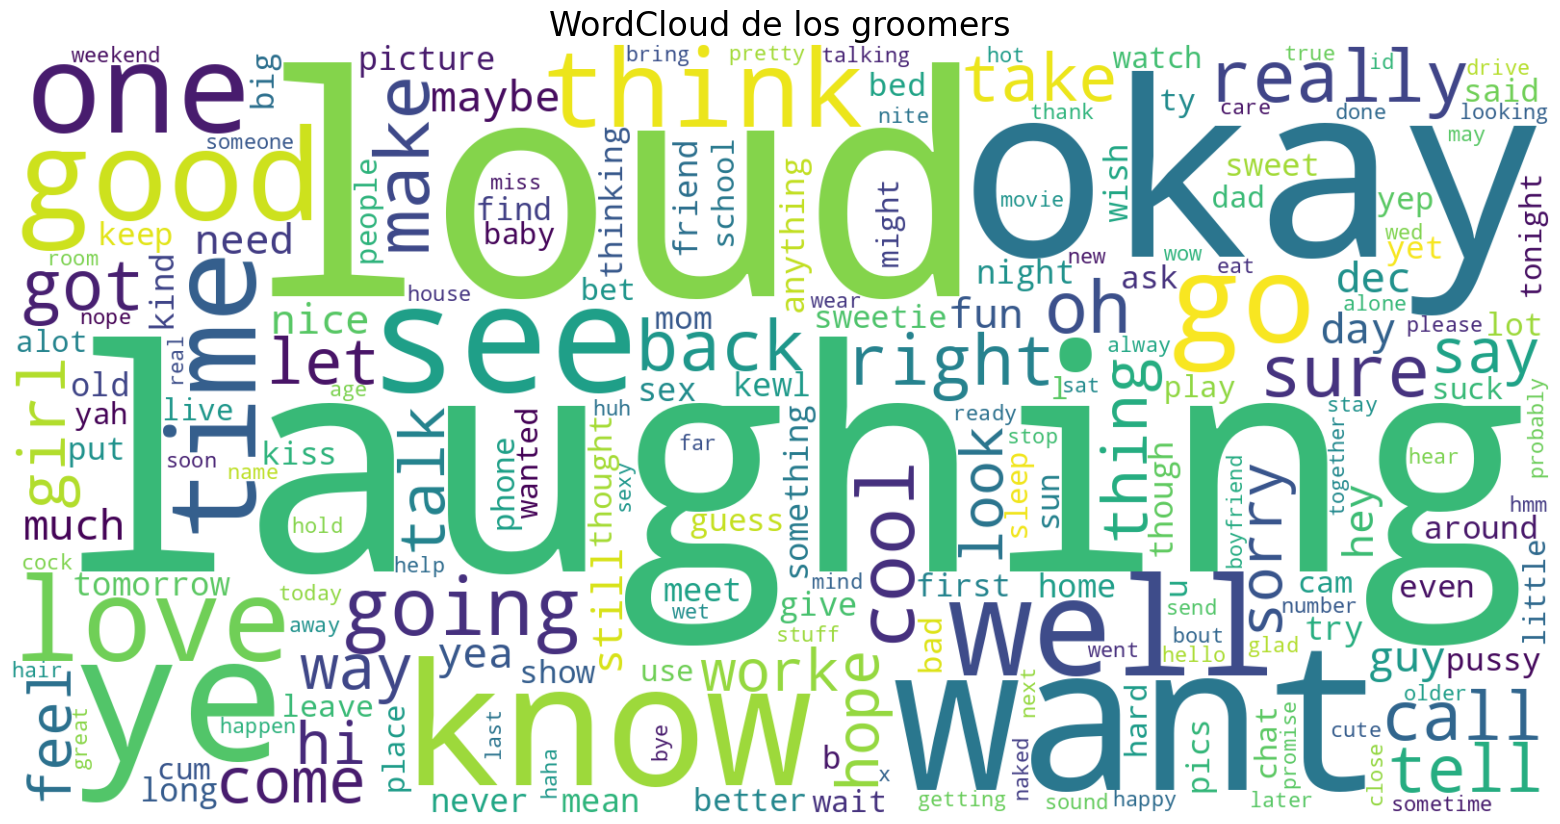

In [123]:
# Une todos los textos del cuerpo de los mensajes en una sola cadena
predator_text = ' '.join(combined_df[combined_df['role'] == 'predator']['normalized_body'].dropna().astype(str))

predator_text = predator_text.lower()

stop_words = set(stopwords.words('english'))

predator_text = re.sub(r'\d+', '', predator_text)
predator_text = re.sub(r'[^\w\s]', '', predator_text)

palabras = [word for word in predator_text.split() if word not in stop_words]

# Crea el objeto WordCloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(' '.join(palabras))

# Mostrar el WordCloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de los groomers", fontsize=24)
plt.show()

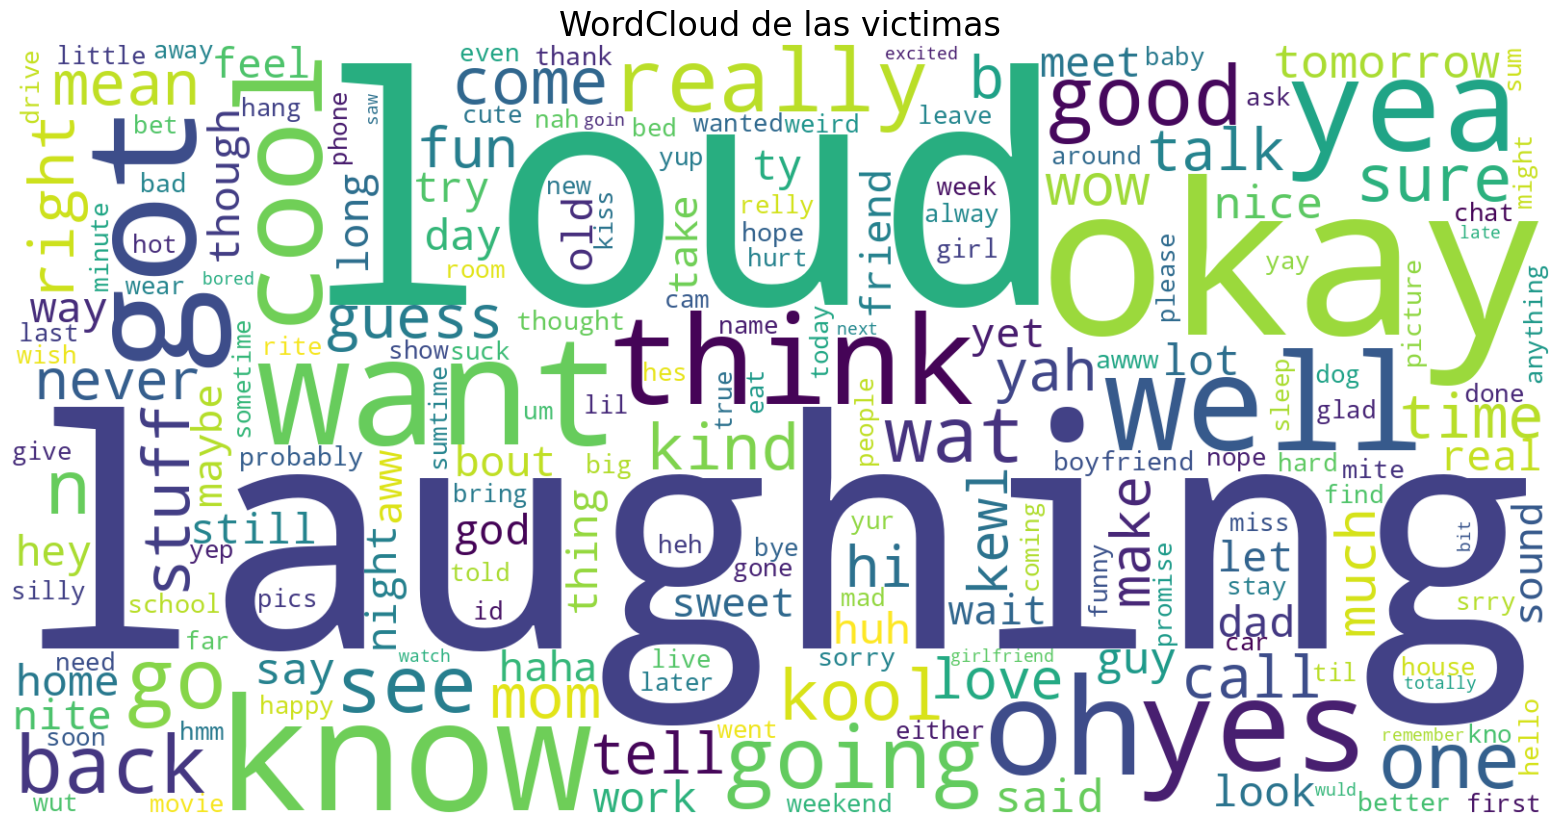

In [124]:

# Une todos los textos del cuerpo de los mensajes en una sola cadena
victim_text = ' '.join(combined_df[combined_df['role'] == 'victim']['normalized_body'].dropna().astype(str))

victim_text = victim_text.lower()

stop_words = set(stopwords.words('english'))

victim_text = re.sub(r'\d+', '', victim_text)
victim_text = re.sub(r'[^\w\s]', '', victim_text)

palabras = [word for word in victim_text.split() if word not in stop_words]

# Crea el objeto WordCloud
wordcloud = WordCloud(width=1600, height=800, background_color='white', collocations=False).generate(' '.join(palabras))

# Mostrar el WordCloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud de las victimas", fontsize=24)
plt.show()

Se ha visualizado varios "Slangs" que usan tanto los groomers como las victimas, por lo que se ha creado un diccionario para poder entender mejor las palabras usadas y pasarlas a palabras mas formales

 **Cantidad de mensajes de predadores y victimas en el archivo de ejemplo**

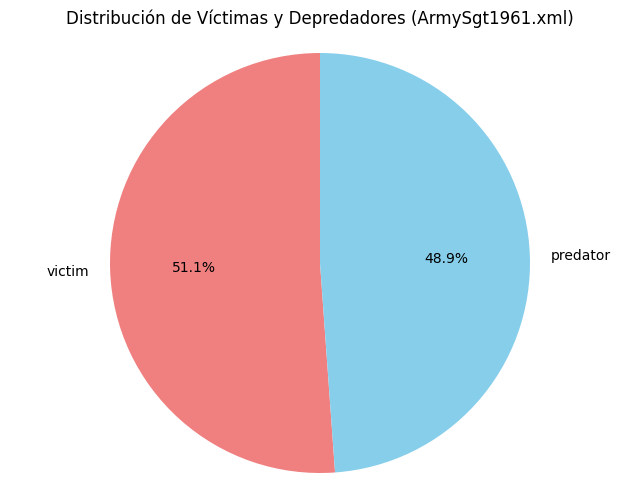

In [125]:
conteo = combined_df['role'].value_counts()

conteo = conteo[conteo.index.isin(['victim', 'predator'])]

plt.figure(figsize=(8, 6))
plt.pie(conteo, labels=conteo.index, autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
plt.title('Distribución de Víctimas y Depredadores (ArmySgt1961.xml)')
plt.axis('equal')

plt.show()

Contador de la longitud de palabras en archivo *'ArmySgt1961.xml'*

In [126]:
combined_df['word_length'] = combined_df['normalized_body'].str.split().str.len()

# Mostrar las primeras filas para verificar
print(combined_df[['role', 'normalized_body', 'word_length']].head())


       role                                     normalized_body  word_length
0  predator                                                  hi            1
1    victim                                                heya            1
2  predator                                  where are you from            4
3    victim  where i from or where i am now what is you are asl           13
4  predator                                   where are you now            4


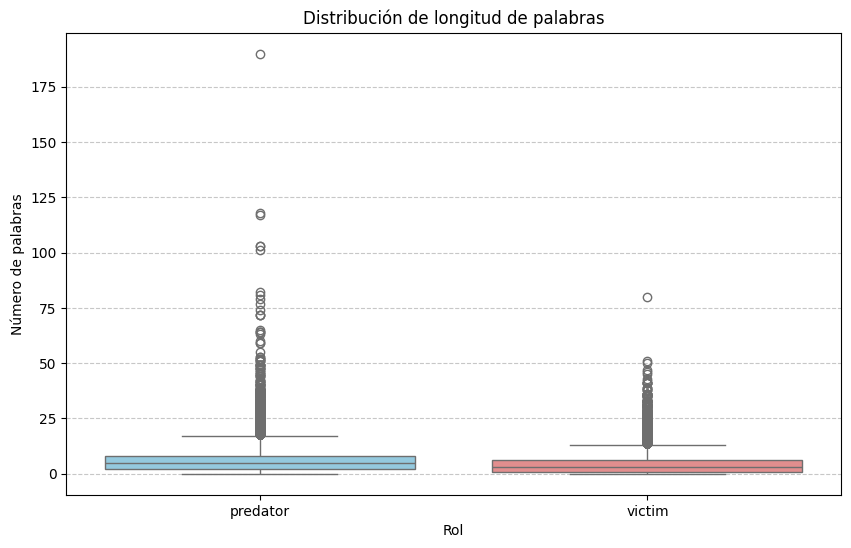

In [127]:
import seaborn as sns

# Filtrar datos
df_filtered = combined_df[combined_df['role'].isin(['victim', 'predator'])]

plt.figure(figsize=(10, 6))
sns.boxplot(
    x='role',
    y='word_length',
    hue='role',  # <- Añadimos hue para evitar el warning
    data=df_filtered,
    palette={'victim': 'lightcoral', 'predator': 'skyblue'},
    legend=False  # <- Ocultamos leyenda si no es necesaria
)
plt.title('Distribución de longitud de palabras')
plt.xlabel('Rol')
plt.ylabel('Número de palabras')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
#plt.ylim(0, 20)   Mostrar solo mensajes con menos de 20 palabras

plt.show()

In [128]:
pd.set_option('display.max_colwidth', None)  # Desactiva el recorte
print(combined_df[combined_df['role'] == 'predator'].nlargest(1, 'word_length')['normalized_body'])


29631    hi love i have look too see if you came back on a few times i did not like how our talk ended that day i am wondering if i made you upset if i did i am very so sorry i am sorry that one guy hurt you and got you in trouble that one time from our chat that day i was thinking that i sounded like him and i am so so so sorry i totally understand and it hurts me so bad that what happen too you interfer your trust in me fully you are too good of a young women so nice i cannot do that too you i am sorry if i made you feel otherwise i worry about you hunny and i am sad because of this and too let you know i will wait that week of that weekend for that info okay i hope it b toward the beginning of the week i hope you do not think different about me i have something too show you on cam mon night i b on around 10 15 10 30 the regular
Name: normalized_body, dtype: object


In [129]:

#combined_df['datetime'] = pd.to_datetime(combined_df['datetime'], errors='coerce')
dt_data = combined_df['datetime']

fecha_df = pd.DataFrame({'datetime_str': dt_data})

def preprocess_datetime(dt_str):

    if pd.isna(dt_str) or not isinstance(dt_str, str):
        return None

    #Sacar parentesis
    dt_str = dt_str.strip("()")

    #Sacar corchetes
    dt_str = dt_str.strip("[]")

    # Sacar espacios
    re.sub(r'\s+', ' ', dt_str).strip()

    # Estandarizar am/pm
    dt_str = dt_str.replace('a.m.', 'am').replace('p.m.', 'pm')
    dt_str = dt_str.replace('A.M.', 'AM').replace('P.M.', 'PM')

    if not dt_str:
        return None
    return dt_str

fecha_df['datetime_limpio'] = fecha_df['datetime_str'].apply(preprocess_datetime)
print(fecha_df[['datetime_str', 'datetime_limpio']].head(20))

              datetime_str       datetime_limpio
0   (09/07/06 11:10:24 pm)  09/07/06 11:10:24 pm
1   (09/07/06 11:10:40 pm)  09/07/06 11:10:40 pm
2   (09/07/06 11:11:17 pm)  09/07/06 11:11:17 pm
3   (09/07/06 11:11:29 pm)  09/07/06 11:11:29 pm
4   (09/07/06 11:11:45 pm)  09/07/06 11:11:45 pm
5   (09/07/06 11:11:46 pm)  09/07/06 11:11:46 pm
6   (09/07/06 11:11:52 pm)  09/07/06 11:11:52 pm
7   (09/07/06 11:12:02 pm)  09/07/06 11:12:02 pm
8   (09/07/06 11:12:07 pm)  09/07/06 11:12:07 pm
9   (09/07/06 11:12:30 pm)  09/07/06 11:12:30 pm
10  (09/07/06 11:12:48 pm)  09/07/06 11:12:48 pm
11  (09/07/06 11:13:05 pm)  09/07/06 11:13:05 pm
12  (09/07/06 11:13:09 pm)  09/07/06 11:13:09 pm
13  (09/07/06 11:13:31 pm)  09/07/06 11:13:31 pm
14  (09/07/06 11:13:40 pm)  09/07/06 11:13:40 pm
15  (09/07/06 11:13:41 pm)  09/07/06 11:13:41 pm
16  (09/07/06 11:13:56 pm)  09/07/06 11:13:56 pm
17  (09/07/06 11:14:01 pm)  09/07/06 11:14:01 pm
18  (09/07/06 11:14:07 pm)  09/07/06 11:14:07 pm
19  (09/07/06 11:14:

In [130]:
# Formato fecha y hora
formats_to_try = [
    "%m/%d/%Y %I:%M:%S %p",  # ej, 5/12/2006 1:53:15 pm
    "%m/%d/%y %I:%M:%S %p",  # ej, 10/01/08 9:43:46 pm
    "%I:%M:%S %p",           # ej, 7:14:04 pm
    "%I:%M %p"
]
fecha_df['datetime_parseado'] = pd.NaT

for i, row in fecha_df.iterrows():
    val_limpio = row['datetime_limpio']
    if pd.isna(val_limpio):
        continue

    parseado = False
    for fmt in formats_to_try:
        try:
            fecha_df.loc[i, 'datetime_parseado'] = pd.to_datetime(val_limpio, format=fmt)
            parseado = True
            break
        except ValueError:
            continue

print(fecha_df[['datetime_str', 'datetime_limpio', 'datetime_parseado']].head(20))

unparsed = fecha_df[fecha_df['datetime_parseado'].isna() & fecha_df['datetime_limpio'].notna()]
if not unparsed.empty:
    print(f"\n {len(unparsed)} Entradas no pudieron ser parseadas:")
    print(unparsed[['datetime_str', 'datetime_limpio']])
    print("\nEntradas no parseadas:")
    print(unparsed['datetime_limpio'].value_counts())
else:
    print("\nEntradas datetime no nulas ya parseadas o limpias.")

              datetime_str       datetime_limpio   datetime_parseado
0   (09/07/06 11:10:24 pm)  09/07/06 11:10:24 pm 2006-09-07 23:10:24
1   (09/07/06 11:10:40 pm)  09/07/06 11:10:40 pm 2006-09-07 23:10:40
2   (09/07/06 11:11:17 pm)  09/07/06 11:11:17 pm 2006-09-07 23:11:17
3   (09/07/06 11:11:29 pm)  09/07/06 11:11:29 pm 2006-09-07 23:11:29
4   (09/07/06 11:11:45 pm)  09/07/06 11:11:45 pm 2006-09-07 23:11:45
5   (09/07/06 11:11:46 pm)  09/07/06 11:11:46 pm 2006-09-07 23:11:46
6   (09/07/06 11:11:52 pm)  09/07/06 11:11:52 pm 2006-09-07 23:11:52
7   (09/07/06 11:12:02 pm)  09/07/06 11:12:02 pm 2006-09-07 23:12:02
8   (09/07/06 11:12:07 pm)  09/07/06 11:12:07 pm 2006-09-07 23:12:07
9   (09/07/06 11:12:30 pm)  09/07/06 11:12:30 pm 2006-09-07 23:12:30
10  (09/07/06 11:12:48 pm)  09/07/06 11:12:48 pm 2006-09-07 23:12:48
11  (09/07/06 11:13:05 pm)  09/07/06 11:13:05 pm 2006-09-07 23:13:05
12  (09/07/06 11:13:09 pm)  09/07/06 11:13:09 pm 2006-09-07 23:13:09
13  (09/07/06 11:13:31 pm)  09/07/

/tmp/ipython-input-131-4024744203.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fecha_df_valid_dates['hora_del_dia'] = fecha_df_valid_dates['datetime_parseado'].dt.hour


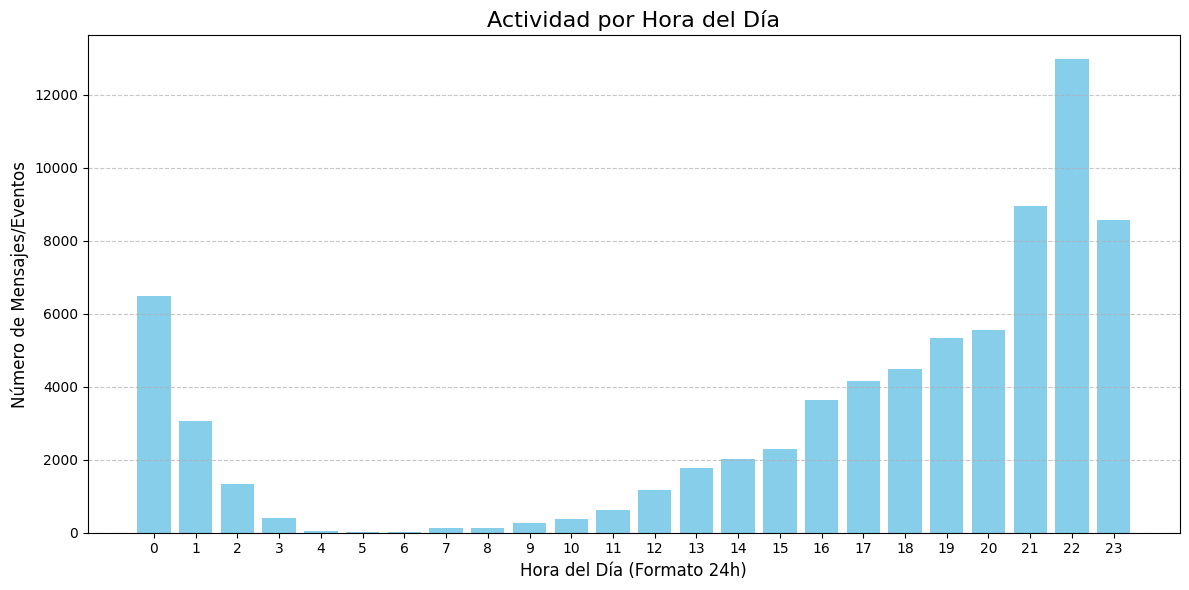


Tabla de actividad por hora del día:
hora_del_dia
0      6491
1      3069
2      1341
3       399
4        50
5        14
6        12
7       133
8       135
9       274
10      373
11      622
12     1178
13     1760
14     2015
15     2294
16     3635
17     4143
18     4493
19     5342
20     5563
21     8964
22    12977
23     8567
Name: count, dtype: int64


In [131]:
fecha_df['datetime_parseado'] = pd.to_datetime(fecha_df['datetime_parseado'], errors='coerce')

# Extraer la hora del dia
fecha_df_valid_dates = fecha_df.dropna(subset=['datetime_parseado'])
fecha_df_valid_dates['hora_del_dia'] = fecha_df_valid_dates['datetime_parseado'].dt.hour

# Contar la actividad por hora
actividad_por_hora = fecha_df_valid_dates['hora_del_dia'].value_counts().sort_index()

# Graficar
plt.figure(figsize=(12, 6))
plt.bar(actividad_por_hora.index, actividad_por_hora.values, color='skyblue', width=0.8)

plt.title('Actividad por Hora del Día', fontsize=16)
plt.xlabel('Hora del Día (Formato 24h)', fontsize=12)
plt.ylabel('Número de Mensajes/Eventos', fontsize=12)
plt.xticks(ticks=range(0, 24), labels=[str(h) for h in range(0, 24)])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nTabla de actividad por hora del día:")
print(actividad_por_hora)

# Preparacion ML


In [132]:
chats_agrupados = combined_df.groupby('file')['normalized_body'].apply(lambda msgs : ' '.join(msgs)).reset_index()
chats_agrupados.columns = ['file','full_chat']
chats_agrupados['label'] = 1


In [133]:
grooming_chats_agrupados = chats_agrupados.drop(columns=['file'])

In [134]:
longitudes = grooming_chats_agrupados['full_chat'].str.len()
indice_max = longitudes.idxmax()
indice_min = longitudes.idxmin()

filas_larguisimas = []

for i, chat in enumerate(grooming_chats_agrupados['full_chat']):
    if len(chat) < 40000:
        print(f"fila {i}: {len(chat)} caracteres")

    else:
        filas_larguisimas.append(i)

fila 0: 2228 caracteres
fila 1: 8919 caracteres
fila 2: 2772 caracteres
fila 4: 24258 caracteres
fila 5: 14962 caracteres
fila 6: 2558 caracteres
fila 7: 8438 caracteres
fila 8: 5154 caracteres
fila 9: 9455 caracteres
fila 10: 23009 caracteres
fila 11: 21563 caracteres
fila 12: 2611 caracteres
fila 13: 2199 caracteres
fila 16: 24208 caracteres
fila 17: 15852 caracteres
fila 18: 32352 caracteres
fila 19: 5012 caracteres
fila 20: 5966 caracteres
fila 21: 1736 caracteres
fila 23: 29833 caracteres
fila 24: 4669 caracteres
fila 25: 4764 caracteres
fila 26: 37520 caracteres
fila 27: 18069 caracteres
fila 28: 2445 caracteres
fila 29: 13353 caracteres
fila 30: 6168 caracteres
fila 31: 27791 caracteres
fila 32: 36317 caracteres
fila 33: 8250 caracteres
fila 34: 16196 caracteres
fila 35: 18652 caracteres
fila 37: 4147 caracteres
fila 39: 25333 caracteres
fila 40: 15915 caracteres
fila 41: 24238 caracteres
fila 42: 24627 caracteres
fila 43: 26322 caracteres
fila 44: 3053 caracteres
fila 46: 16425

In [135]:
grooming_chats_agrupados = grooming_chats_agrupados.drop(filas_larguisimas)

In [136]:
grooming_chats_agrupados

full_chat  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Viendo la cantidad de full chats que hay y cuantos caracteres tienen para compararlos con dataset de no grooming

In [137]:
grooming_chats_agrupados["full_chat"].str.len().describe()

count       47.000000
mean     14629.340426
std      10503.474299
min       1736.000000
25%       4888.000000
50%      14962.000000
75%      23608.500000
max      37520.000000
Name: full_chat, dtype: float64

In [138]:
for i, chat in enumerate(grooming_chats_agrupados['full_chat']):
    print(f"fila {i}: {len(chat)} caracteres")

fila 0: 2228 caracteres
fila 1: 8919 caracteres
fila 2: 2772 caracteres
fila 3: 24258 caracteres
fila 4: 14962 caracteres
fila 5: 2558 caracteres
fila 6: 8438 caracteres
fila 7: 5154 caracteres
fila 8: 9455 caracteres
fila 9: 23009 caracteres
fila 10: 21563 caracteres
fila 11: 2611 caracteres
fila 12: 2199 caracteres
fila 13: 24208 caracteres
fila 14: 15852 caracteres
fila 15: 32352 caracteres
fila 16: 5012 caracteres
fila 17: 5966 caracteres
fila 18: 1736 caracteres
fila 19: 29833 caracteres
fila 20: 4669 caracteres
fila 21: 4764 caracteres
fila 22: 37520 caracteres
fila 23: 18069 caracteres
fila 24: 2445 caracteres
fila 25: 13353 caracteres
fila 26: 6168 caracteres
fila 27: 27791 caracteres
fila 28: 36317 caracteres
fila 29: 8250 caracteres
fila 30: 16196 caracteres
fila 31: 18652 caracteres
fila 32: 4147 caracteres
fila 33: 25333 caracteres
fila 34: 15915 caracteres
fila 35: 24238 caracteres
fila 36: 24627 caracteres
fila 37: 26322 caracteres
fila 38: 3053 caracteres
fila 39: 16425 

Ahora que hemos eliminado las filas mas largas usaremos un dataset de conversaciones

# ***PARA GOOGLE COLAB, COMENTAR SI NO SE USA***

In [139]:
!pip install --upgrade datasets

In [140]:
from datasets import load_dataset

dataset = load_dataset("daily_dialog", trust_remote_code=True)

In [141]:
dialog_data = dataset['train'].to_pandas()

In [142]:
dialog_data['dialog'] = dialog_data['dialog'].apply(lambda x: ' '.join(eval(x)) if isinstance(x, str) and x.startswith('[') else ' '.join(x) if isinstance(x,list) else str(x))
dialog_data['normalized_dialog'] = dialog_data['dialog'].apply(normalize_text)

In [143]:
dialog_data = dialog_data.drop(columns=['act'])
dialog_data = dialog_data.drop(columns=['emotion'])
dialog_data['label'] = 0

In [144]:
dialog_chats_agrupados = dialog_data[['normalized_dialog']].copy()
dialog_chats_agrupados.rename(columns={'normalized_dialog': 'full_chat'}, inplace=True)
dialog_chats_agrupados['label'] = 0


In [145]:
dialog_chats_agrupados

full_chat  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     say jim how about going for a few beers after dinner you know that is tempting but is really not good for our fitness what do you mean it will help us to relax do you really think so i do not it will just make us fat and act silly remember last time i guess you are right but what shall we do i do not feel like sitting at home i suggest a walk over to the gym where we can play singsong and meet some of our friends that is a good idea i hear mary and sally often go there to play pingpong perhaps we can make a foursome with them sounds great to me if they are willing we could ask them to go dancing with us that is excellent exercise and fun too good let s go now all right   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           can you do push ups of course i can it is a piece of cake believe it or not i can do 30 push ups a minute really i think that is impossible you mean 30 push ups yes it is easy if you do exercise everyday you can make it too   
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             can you study with the radio on no i listen to background music what is the difference the radio has too many comerials that is true but then you have to buy a record player   
3                                                                                                                                                                                                     

In [146]:
# Concatenación de diálogos con label 0, agrupando de 40 en 40 (optimo para promedio y std vs dialogos de grooming)
df_label_0 = dialog_chats_agrupados[dialog_chats_agrupados["label"] == 0].reset_index(drop=True)

grupo = 40
concatenados = []

for i in range(0, len(df_label_0), grupo):
    fragmento = df_label_0.iloc[i:i+grupo]["full_chat"]
    texto_concatenado = " ".join(fragmento)
    concatenados.append(texto_concatenado)

dialog_chats_agrupados_concat = pd.DataFrame({
    "full_chat": concatenados,
    "label": 0
})



In [147]:
dialog_chats_agrupados_concat

full_chat  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [154]:
dialog_chats_agrupados_concat["full_chat"].str.len().describe()


count      278.000000
mean     17832.550360
std       2095.814632
min      12283.000000
25%      16364.750000
50%      17784.000000
75%      19231.750000
max      24488.000000
Name: full_chat, dtype: float64

*Se usa el 20% de una muestra aletoria de la concatenacion de los full chats de no grooming para ser similar al dataset de los chats de grooming*

In [165]:
dialog_chats_agrupados_concat_25pct = dialog_chats_agrupados_concat.sample(frac=0.20, random_state=42)
dialog_chats_agrupados_concat_25pct["full_chat"].str.len().describe()

count       56.000000
mean     17870.750000
std       2281.438312
min      14349.000000
25%      16032.750000
50%      17512.500000
75%      19644.500000
max      24488.000000
Name: full_chat, dtype: float64

In [166]:
datos_para_ml = pd.concat([grooming_chats_agrupados, dialog_chats_agrupados_concat_25pct], ignore_index=True)


In [167]:
output_filename = 'datos_finales_para_ml_rev2.csv'
try:
    datos_para_ml.to_csv(output_filename, index=False)
    print(f"\n DF final para ML guardado en: {output_filename}")
except Exception as e:
    print(f"Error al guardar el archivo: {e}")


 DF final para ML guardado en: datos_finales_para_ml_rev2.csv
